# Dati evento

In questo notebook vedremo come gestire i dati evento, come visualizzarli sul campo e come ricavarne metriche specifiche.


In [1]:
#importazione librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, interpolate
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mplsoccer.pitch import Pitch, VerticalPitch
from mplsoccer import PyPizza, Radar
from highlight_text import fig_text
from adjustText import adjust_text
from database.read_db import *


                full_name
0      Fabio Quagliarella
1         Andrea Consigli
2           Miguel Veloso
3            Rui Patrício
4          Daniel Ciofani
..                    ...
310          Yayah Kallon
311  Federico Baschirotto
312        Jacopo Fazzini
313      Felix Afena-Gyan
314         Joan González

[315 rows x 1 columns]


Iniziamo caricando i dati.

In [2]:
df = read_db('ds.team_player_events')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655086 entries, 0 to 655085
Data columns (total 58 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  655086 non-null  int64         
 1   competition_id      655086 non-null  int64         
 2   season              655086 non-null  int64         
 3   home_team_id        655086 non-null  int64         
 4   player_id           655086 non-null  int64         
 5   away_team_id        655086 non-null  int64         
 6   matchday            655086 non-null  int64         
 7   game_id             655086 non-null  int64         
 8   home_score          655086 non-null  int64         
 9   away_score          655086 non-null  int64         
 10  type_id             655086 non-null  int64         
 11  team_id             655086 non-null  int64         
 12  sec                 655086 non-null  float64       
 13  Q                   613634 no

Vediamo che il dataset contiene per ogni evento informazioni su giocatore (`player_id`, `player`), squadra (`team_id`, `team`), coordinate sul campo (`x`, `y`), tempo di gioco (`period_id`, `min`, `sec`), tipo di evento (`type_id`) e risultato (`outcome`). L'interpretazione di ID numerici come il `type_id` va fatta guardando la documentazione Opta dei dati evento. Vediamo anche molte informazioni aggiuntive sul tipo di evento, situazione di gioco etc., che sono state estratte dalla colonna `Q`, contenente i cosiddetti qualifiers.

Vediamo come estrarre un qualifier dalla colonna Q usando delle funzioni specifiche. Per prima cosa vediamo come è fatto questo dato.

In [4]:
df.iloc[0]['Q']

"[{'@attributes': {'id': '3702698499', 'value': '161918', 'qualifier_id': '194'}}, {'@attributes': {'id': '3702698489', 'value': '16, 2, 19, 33, 20, 23, 30, 4, 12, 10, 17, 1, 5, 7, 9, 14, 24, 25, 27, 32, 46, 56, 83, 90', 'qualifier_id': '59'}}, {'@attributes': {'id': '3703034905', 'value': '578', 'qualifier_id': '197'}}, {'@attributes': {'id': '3702698493', 'value': '8', 'qualifier_id': '130'}}, {'@attributes': {'id': '3702698485', 'value': '1, 2, 2, 3, 2, 2, 3, 3, 4, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5', 'qualifier_id': '44'}}, {'@attributes': {'id': '3702698495', 'value': '1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0', 'qualifier_id': '131'}}, {'@attributes': {'id': '3702698483', 'value': '129487, 161918, 222784, 155748, 466041, 194794, 432070, 202041, 98456, 216183, 216065, 44898, 225897, 437504, 44346, 169102, 48714, 97617, 152760, 459025, 215979, 437746, 12730, 465716', 'qualifier_id': '30'}}, {'@attributes': {'id': '3702698503', 'value': '0, 0,

Si tratta di una lista di dizionari abbastanza complessa, dovuta alla struttura innestata del dato grezzo, che necessita delle funzioni definite a mano per estrarre informazioni. A questo fine definiamo alcune funzioni (questo è solo un modo per ottenere il risultato).

In [5]:
def eval_q(x):
    return eval(x.replace("null", "None"))

def get_numeric_q(x,qid):
    for l in x:
        if l['@attributes']['qualifier_id'] == str(qid):
            return float(l['@attributes']['value'])

def get_binary_q(x,qid):
    bl = []
    for l in x:
        if l['@attributes']['qualifier_id'] == str(qid):
            bl.append(True)
        else:
            bl.append(False)
    bl = np.asarray(bl)
    if bl.any():
        return True
    else:
        return False

In [6]:
df = df.dropna(subset = ['Q'])
df['Q'] = df.Q.apply(eval_q)

Come esempio, estraiamo un qualifier binario (vero/falso) e uno numerico.

In [7]:
df['through_ball'] = df.Q.apply(get_binary_q, args = [4])
df['length'] = df.Q.apply(get_numeric_q, args = [212])

<Axes: >

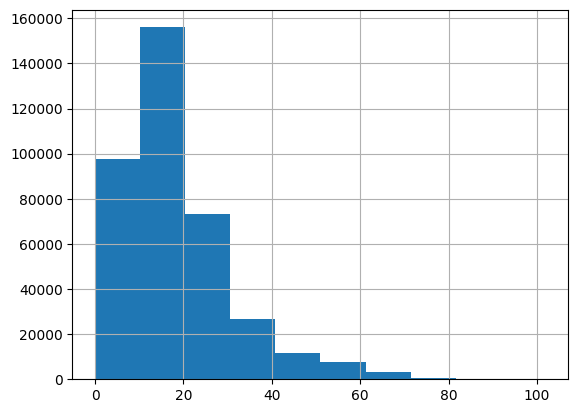

In [8]:
df.length.hist()

# Visualizzare i dati evento sul campo

Usando la funzione `Pitch` di MplSoccer possiamo creare un campo su cui inserire i nostri eventi (documentazione completa: https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_setup/plot_pitches.html).

Per inizializzare il grafico e creare un oggetto figura di matplotlib, usiamo la funzione `draw`, impostando anche la dimensione del grafico, che in realtà verrà letta solo per il lato lungo perché il campo da calcio non è quadrato. Per visualizzare eventi come i tiri possiamo usare un semplice scatterplot sul nostro campo in base alle coordinate, usando la funzione `scatter` tramite l'oggetto `pitch` che abbiamo creato. Questa funzione usa la solita funzione `scatter` di Matplotlib ma gestisce automaticamente le coordinate in modo che vengano rappresentate correttamente sul campo. Infine, possiamo distinguere i tiri dai gol impostando per i primi solo il colore del bordo, lasciando trasparente l'interno del punto, e viceversa per i secondi. 

Per distinguere i gol nei dati Opta va usato il `type_id`. I tiri corrispondono ai tipi 13,14,15 e 16 a seconda del risultato, dove il gol corrisponde a quest'ultimo.

Nel primo esempio andiamo a visualizzare tutti i tiri di Osimhen.

In [9]:
df['goal'] = df.type_id == 16

df_shots = df[df.type_id.isin([13, 14, 15, 16]) & (df.own_goal == False) & (df.player_id == 218329)]

df_goals = df_shots[df_shots.goal == True]
df_shots = df_shots[df_shots.goal == False]

È possibile impostare il campo in modo che sia orizzontale o verticale, ed è anche possibile ritagliarlo in modo da mostrare solo la metà campo offensiva, nei casi in cui questa opzione è appropriata (come per esempio in una mappa di tiri)

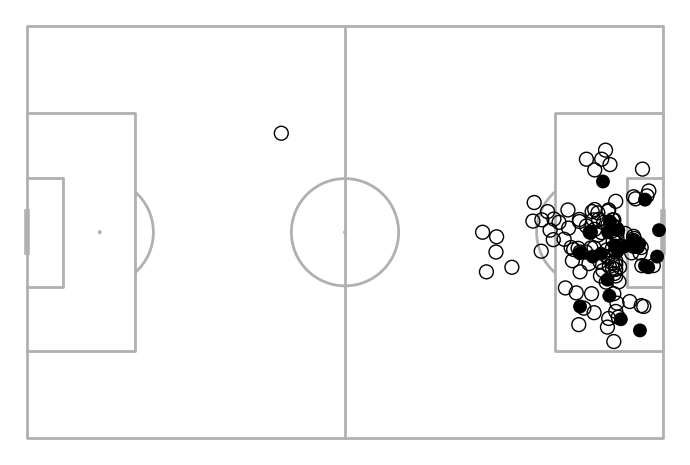

In [10]:
pitch = Pitch(pitch_type = 'opta')
# pitch = VerticalPitch(pitch_type = 'opta')
# pitch = VerticalPitch(pitch_type = 'opta', half = True)

f, ax = pitch.draw(figsize=(7,7))
pitch.scatter(x = df_shots.x,
              y = df_shots.y,
              s = 100,
              color = 'none',
              edgecolor = 'black',
              zorder = 10,
              ax = ax)
pitch.scatter(x = df_goals.x,
              y = df_goals.y,
              s = 100,
              color = 'black',
              edgecolor = 'none',
              zorder = 10,
              ax = ax)
plt.show()

Questo tipo di rappresentazione si può ovviamente usare per tutti i tipi di evento, per esempio per evidenziare le azioni difensive o i dribbling.

Vediamo che per alcuni eventi abbiamo a disposizione non solo le coordinate di partenza ma anche quelle di arrivo (`end_x`, `end_y`). Si tratta naturalmente dei passaggi, per cui possiamo visualizzare entrambe queste informazioni. Un possibile modo di rappresentarle è di tracciare una linea dal punto di partenza a quello di arrivo (col la funzione `lines`), insieme a uno scatterplot dei punti di arrivo.

Come esempio, visualizziamo tutti i rinvii dal fondo del Milan in una partita scelta a caso.

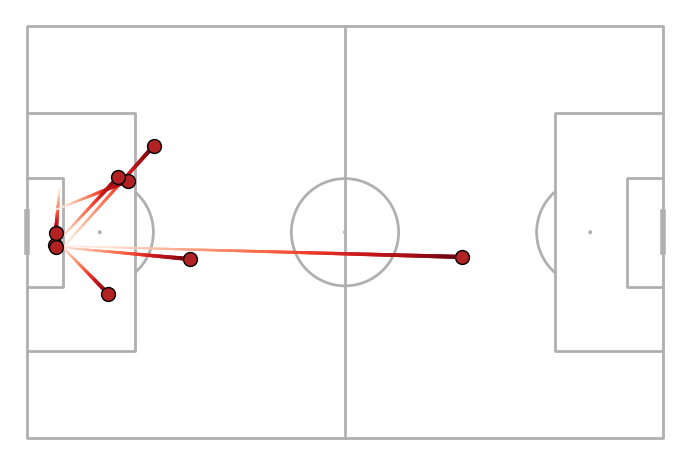

In [11]:
dfgk = df[(df.type_id == 1) & (df.team_id == 120) & (df.game_id == df[df.team_id == 120].game_id.unique()[-1]) & (df.goal_kick == True)]

pitch = Pitch(pitch_type = 'opta')

f, ax = pitch.draw(figsize=(7,7))
pitch.lines(dfgk.x,
            dfgk.y,
            dfgk.end_x,
            dfgk.end_y,
            lw=3,
            comet = True,
            #color = 'b',
            cmap = 'Reds',
            # alpha = 0.5,
            ax=ax)
pitch.scatter(x = dfgk.end_x,
              y = dfgk.end_y,
              s = 100,
              color = 'firebrick',
              edgecolor = 'black',
              zorder = 10,
              ax = ax)
plt.show()

Se abbiamo a che fare con molti eventi, questo tipo di rappresentazione potrebbe risultare troppo affollato, per cui si cerca di combinare i valori, per esempio con una *heatmap*. Prendiamo per esempio tutti i passaggi dell'Inter in una partita.

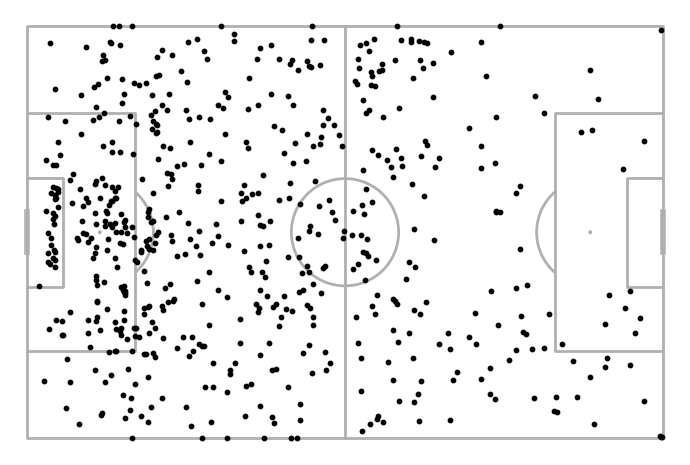

In [14]:
dfip = df[(df.type_id == 1) & (df.team_id == 127) & (df.game_id == df[df.team_id == 127].game_id.unique()[-1])]

pitch = Pitch(pitch_type = 'opta', line_zorder = 1)

f, ax = pitch.draw(figsize=(7,7))
pitch.scatter(x = dfip.x,
              y = dfip.y,
              s = 10,
              color = 'black',
              zorder = 10,
              ax = ax)
plt.show()

Questa visualizzazione non ci fornisce le informazioni nel modo più adatto. Vediamo come calcolare e visualizzare una heatmap in MplSoccer usando le funzioni `bin_statistic` e `heatmap`. Aggiungiamo anche una barra di colore che codifichi la heatmap con la funzione `colorbar`.

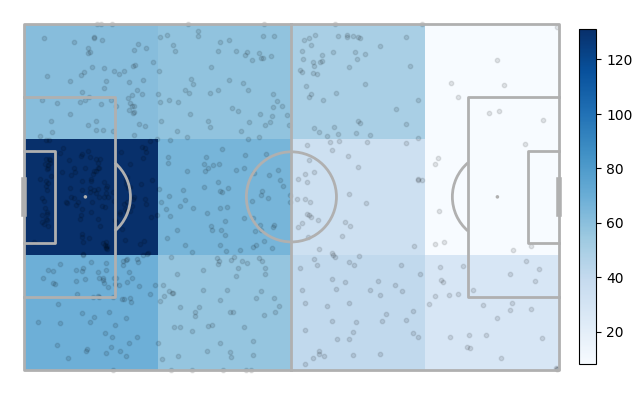

In [15]:
pitch = Pitch(pitch_type = 'opta', line_zorder = 100)

f, ax = pitch.draw(figsize=(7,7))
#la funzione bin_statistic prende in input le due coordinate, una statistica da calcolare nel bin, e il numero di bin nelle due direzioni
bin_statistic = pitch.bin_statistic(dfip.x, dfip.y, statistic='count', bins=(4,3))
pcm = pitch.heatmap(bin_statistic, cmap='Blues', ax=ax)
pitch.scatter(x = dfip.x,
              y = dfip.y,
              s = 10,
              color = 'black',
              zorder = 10,
              alpha = 0.1,
              ax = ax)
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01)
plt.show()

In questo modo vediamo molto più chiaramente dove si concentrano i passaggi. Possiamo visualizzare la distribuzione in modo più "sfumato" usando uno smussamento tramite un filtro Gaussiano dopo aver calcolato la griglia con un numero maggiore di punti, tramite la funzione `gaussian_filter` della libreria SciPy.

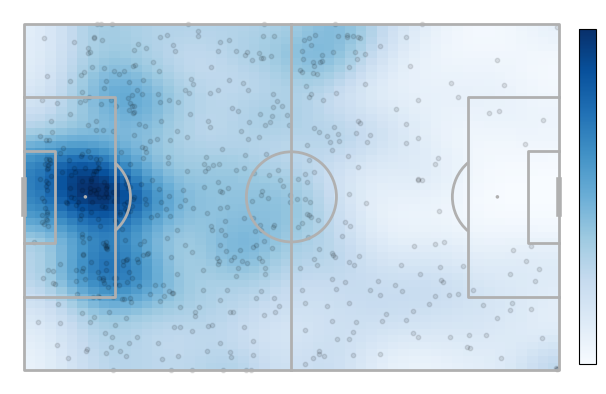

In [16]:
pitch = Pitch(pitch_type = 'opta', line_zorder = 100)

f, ax = pitch.draw(figsize=(7,7))
bin_statistic = pitch.bin_statistic(dfip.x, dfip.y, statistic='count', bins=(50,50))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 3)
pcm = pitch.heatmap(bin_statistic, cmap='Blues', ax=ax)
pitch.scatter(x = dfip.x,
             y = dfip.y,
             s = 10,
             color = 'black',
             zorder = 10,
             alpha = 0.1,
             ax = ax)
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax = ax)
#in questo caso il valore numerico in ogni bin non è particolarmente informativo perché è "spalmato" dal filtro Gaussiano, quindi possiamo rimuoverlo dalla colorbar per non creare confusione
cbar.set_ticks([])
plt.show()

In molti casi è opportuno ripulire il dato escludendo eventi su palla ferma. Nel nostro caso abbiamo già a disposizione le colonne necessarie ad operare questo filtro, e possiamo definirne una nuova.

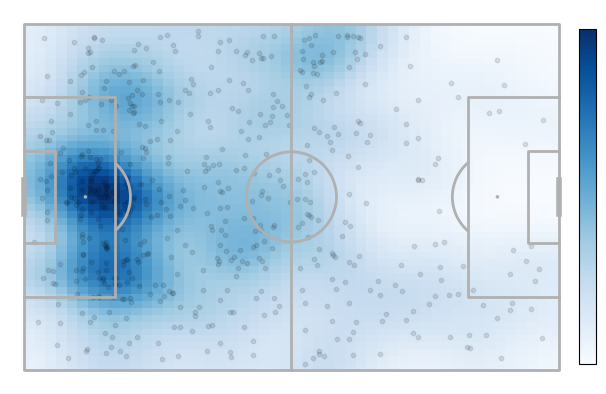

In [18]:
df['open_play'] = df[['direct_free_kick', 'penalty', 'from_corner', 'set_piece', 'free_kick', 'corner', 'throw_in', 'goal_kick', 'kick_off']].sum(axis=1) == 0
dfip = df[(df.type_id == 1) & (df.team_id == 127) & (df.game_id == df[df.team_id == 127].game_id.unique()[-1]) & (df.open_play == True)]


pitch = Pitch(pitch_type = 'opta', line_zorder = 100)

f, ax = pitch.draw(figsize=(7,7))
bin_statistic = pitch.bin_statistic(dfip.x, dfip.y, statistic='count', bins=(50,50))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 3)
pcm = pitch.heatmap(bin_statistic, cmap='Blues', ax=ax)
pitch.scatter(x = dfip.x,
             y = dfip.y,
             s = 10,
             color = 'black',
             zorder = 10,
             alpha = 0.1,
             ax = ax)
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax = ax)
#in questo caso il valore numerico in ogni bin non è particolarmente informativo perché è "spalmato" dal filtro Gaussiano, quindi possiamo rimuoverlo dalla colorbar per non creare confusione
cbar.set_ticks([])
plt.show()

# Estrazione di metriche dettagliate dai dati evento

Avendo a disposizione il livello di granularità più alto possibile con i dati evento, è possibile ricavare metriche specifiche che possano rispondere in modo personalizzato alle richieste di uno specifico staff. Nella maggior parte dei casi questa operazione consiste nell'aggregare un certo sottoinsieme di dati che risponde a delle condizioni specifiche. Un esempio classico è quello dei passaggi progressivi, in cui avendo a disposizione i dati evento si può scegliere liberamente la definizione che si vuole adottare nell'andare a calcolarli.

Per iniziare, selezioniamo tutti i passaggi riusciti su azione (esclusi cross, passaggi di testa e cutbacks), e andiamo poi a definire delle nuove colonne che descrivono la distanza da fondo campo e la distanza dal centro della porta.

In [19]:
exclude_cols = ['cross', 'head_pass', 'free_kick', 'corner', 'throw_in', 'goal_kick', 'cutback', 'kick_off']
dfp = df[(df.type_id == 1) & (df.outcome == 1) & (df[exclude_cols].sum(axis = 1) == 0)]

#conversione delle coordinate da 100simi in metri secondo standard UEFA (105x68)
dfp['x_m'] = dfp.x * 105/100
dfp['y_m'] = dfp.y * 68/100
dfp['end_x_m'] = dfp.end_x * 105/100
dfp['end_y_m'] = dfp.end_y * 68/100

#calcolo lunghezza passaggio in metri
dfp['length'] = np.sqrt((dfp.end_x_m - dfp.x_m)**2 + (dfp.end_y_m - dfp.y_m)**2)

#calcolo distanza da fondo campo e da centro porta
dfp['xGoal'] = 100 - dfp.x
dfp['yGoal'] = dfp.y - 50
dfp['xGoal_end'] = 100 - dfp.end_x
dfp['yGoal_end'] = dfp.end_y - 50

dfp['xGoal_m'] = 105 - dfp.x_m
dfp['yGoal_m'] = dfp.y_m - 34
dfp['xGoal_end_m'] = 105 - dfp.end_x_m
dfp['yGoal_end_m'] = dfp.end_y_m - 34

dfp['gDist_m'] = np.sqrt(dfp.xGoal_m**2 + dfp.yGoal_m**2)
dfp['gDist_m_end'] = np.sqrt(dfp.xGoal_end_m**2 + dfp.yGoal_end_m**2)

dfp['gDist'] = np.sqrt(dfp.xGoal**2 + dfp.yGoal**2)
dfp['gDist_end'] = np.sqrt(dfp.xGoal_end**2 + dfp.yGoal_end**2)

#calcolo distanza progressiva assoluta e percentuale
dfp['prog_dist_goal_m'] = dfp.gDist_m_end - dfp.gDist_m
dfp['prog_dist_x_m'] = dfp.xGoal_end_m - dfp.xGoal_m

dfp['prog_rel_x'] = 100 * (dfp.xGoal_end - dfp.xGoal) / dfp.xGoal
dfp['prog_rel_goal'] = 100 * (dfp.gDist_end - dfp.gDist) / dfp.gDist

/var/folders/jp/hbdkvh057hbcll7yhszxq6y40000gn/T/ipykernel_6695/2106114731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['x_m'] = dfp.x * 105/100
/var/folders/jp/hbdkvh057hbcll7yhszxq6y40000gn/T/ipykernel_6695/2106114731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['y_m'] = dfp.y * 68/100
/var/folders/jp/hbdkvh057hbcll7yhszxq6y40000gn/T/ipykernel_6695/2106114731.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

A questo punto possiamo andare ad aggregare i dati, per esempio per giocatore e squadra, andando ad applicare le condizioni che corrispondono alla definizione individuata.

In [20]:
#25% di progressione su centro porta, 10% su fondo campo
dfpg = dfp[(dfp.prog_rel_goal <= -25.) & (dfp.prog_rel_x <= -10.)].groupby(['player_id', 'team_id', 'player', 'team']).size().sort_values(ascending = False).to_frame('prog_passes_25_10')

#25% di progressione su centro porta e fondo campo
dfpg['prog_passes_25_25'] = dfp[(dfp.prog_rel_goal <= -25.) & (dfp.prog_rel_x <= -25.)].groupby(['player_id', 'team_id', 'player', 'team']).size()

#25% di progressione su centro porta, 10% su fondo campo, esclusi passaggi dal primo terzo
dfpg['prog_passes_25_10_no_ft'] = dfp[(dfp.prog_rel_goal <= -25.) & (dfp.prog_rel_x <= -10.) & (dfp.x >= 100./3)].groupby(['player_id', 'team_id', 'player', 'team']).size()

#10 metri di progressione
dfpg['prog_passes_15m'] = dfp[(dfp.prog_dist_goal_m <= -15.) & (dfp.prog_dist_x_m <= -15.)].groupby(['player_id', 'team_id', 'player', 'team']).size()

dfpg = dfpg.fillna(0).astype(int)
dfpg.head(20)

,,,,prog_passes_25_10,prog_passes_25_25,prog_passes_25_10_no_ft,prog_passes_15m
player_id,team_id,player,team,,,,
93661,459,G. Di Lorenzo,Napoli,197,137,158,166
156245,126,L. Montipò,Verona,183,183,1,237
193773,135,V. Milinkovic-Savic,Torino,172,172,5,266
82451,129,L. Alberto,Lazio,147,102,142,87
100180,128,Danilo,Juventus,139,117,97,175
101019,459,M. Rui,Napoli,134,108,106,119
230650,742,M. Di Gregorio,Monza,133,132,1,251
151923,129,I. Provedel,Lazio,129,129,0,319
431079,603,T. Augello,Sampdoria,129,87,97,118


Un altro esempio potrebbe essere il calcolo del numero di passaggi che entrano in area.

In [21]:
exclude_cols = ['head_pass', 'free_kick', 'corner', 'throw_in', 'goal_kick', 'kick_off']
dfp = df[(df.type_id == 1) & (df.outcome == 1) & (df[exclude_cols].sum(axis = 1) == 0)]

dfp['start_out_box'] = (dfp.x < 83) | (dfp.y < 21.1) | (dfp.y > 78.9)
dfp['end_in_box'] = (dfp.end_x >= 83) & (dfp.end_y >= 21.1) & (dfp.end_y <= 78.9)

dfpg['passes_into_box'] = dfp[(dfp.start_out_box == True) & (dfp.end_in_box == True)].groupby(['player_id', 'team_id', 'player', 'team']).size()

dfpg.sort_values('passes_into_box', ascending = False).head(20)

/var/folders/jp/hbdkvh057hbcll7yhszxq6y40000gn/T/ipykernel_6695/4086439094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['start_out_box'] = (dfp.x < 83) | (dfp.y < 21.1) | (dfp.y > 78.9)
/var/folders/jp/hbdkvh057hbcll7yhszxq6y40000gn/T/ipykernel_6695/4086439094.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['end_in_box'] = (dfp.end_x >= 83) & (dfp.end_y >= 21.1) & (dfp.end_y <= 78.9)


,,,,prog_passes_25_10,prog_passes_25_25,prog_passes_25_10_no_ft,prog_passes_15m,passes_into_box
player_id,team_id,player,team,,,,,
93661,459,G. Di Lorenzo,Napoli,197,137,158,166,61.0
216065,120,R. Leão,Milan,99,67,98,37,59.0
82451,129,L. Alberto,Lazio,147,102,142,87,56.0
101019,459,M. Rui,Napoli,134,108,106,119,55.0
116796,2182,D. Berardi,Sassuolo,65,48,61,34,55.0
45156,1025,A. Candreva,Salernitana,125,84,106,91,55.0
430529,2174,E. Valeri,Cremonese,70,51,61,60,51.0
171384,127,N. Barella,Internazionale,119,93,114,89,50.0
204644,456,T. Koopmeiners,Atalanta,122,109,89,108,50.0


Un altro esempio può essere il calcolo della % di duelli aerei vinti, divisa per duelli offensivi e difensivi.

In [22]:
dfda = df[(df.type_id == 44) | ((df.type_id == 4) & (df.aerial_foul == True))]

dfpg['def_aerials'] = dfda.groupby(['player_id', 'team_id', 'player', 'team']).defensive.sum()
dfpg['def_aerials_won'] = dfda[dfda.defensive == True].groupby(['player_id', 'team_id', 'player', 'team']).outcome.sum()

dfpg['off_aerials'] = dfda.groupby(['player_id', 'team_id', 'player', 'team']).offensive.sum()
dfpg['off_aerials_won'] = dfda[dfda.offensive == True].groupby(['player_id', 'team_id', 'player', 'team']).outcome.sum()

dfpg['soccRole'] = dfda.groupby(['player_id', 'team_id', 'player', 'team']).soccRole.first()

dfpg2 = dfpg[(dfpg.def_aerials >= 10) & (dfpg.soccRole != 'GK')]

dfpg2['def_aerials_win_pct'] = 100 * dfpg2.def_aerials_won / dfpg2.def_aerials
# dfpg2['off_aerials_win_pct'] = 100 * dfpg2.off_aerials_won / dfpg2.off_aerials

dfpg2.sort_values('def_aerials_win_pct', ascending = False).head(20)[['def_aerials', 'def_aerials_won', 'def_aerials_win_pct']]

/var/folders/jp/hbdkvh057hbcll7yhszxq6y40000gn/T/ipykernel_6695/2896947229.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpg2['def_aerials_win_pct'] = 100 * dfpg2.def_aerials_won / dfpg2.def_aerials


,,,,def_aerials,def_aerials_won,def_aerials_win_pct
player_id,team_id,player,team,,,
215979,120,M. Gabbia,Milan,14.0,13.0,92.857143
91990,459,J. Jesus,Napoli,31.0,26.0,83.870968
161490,2174,A. Ferrari,Cremonese,18.0,15.0,83.333333
213602,126,O. Abildgaard,Verona,29.0,24.0,82.758621
50933,603,T. Rincón,Sampdoria,28.0,23.0,82.142857
225897,120,F. Ballo-Touré,Milan,10.0,8.0,80.000000
55909,121,C. Smalling,Roma,69.0,55.0,79.710145
462026,459,L. Østigård,Napoli,32.0,25.0,78.125000
222784,120,T. Hernández,Milan,27.0,21.0,77.777778


In [23]:
dfpg2 = dfpg[(dfpg.off_aerials >= 10) & (dfpg.soccRole != 'GK')]

dfpg2['off_aerials_win_pct'] = 100 * dfpg2.off_aerials_won / dfpg2.off_aerials

dfpg2.sort_values('off_aerials_win_pct', ascending = False).head(20)[['off_aerials', 'off_aerials_won', 'off_aerials_win_pct']]

/var/folders/jp/hbdkvh057hbcll7yhszxq6y40000gn/T/ipykernel_6695/89551430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpg2['off_aerials_win_pct'] = 100 * dfpg2.off_aerials_won / dfpg2.off_aerials


,,,,off_aerials,off_aerials_won,off_aerials_win_pct
player_id,team_id,player,team,,,
53693,128,A. Sandro,Juventus,17.0,15.0,88.235294
78140,127,S. de Vrij,Internazionale,39.0,33.0,84.615385
515952,695,F. Parisi,Empoli,12.0,10.0,83.333333
164099,742,Marlon,Monza,11.0,9.0,81.818182
195516,695,A. Grassi,Empoli,18.0,14.0,77.777778
218514,121,M. Camara,Roma,13.0,10.0,76.923077
105119,742,A. Izzo,Monza,21.0,16.0,76.190476
230152,123,J. Schouten,Bologna,16.0,12.0,75.000000
177901,127,R. Gosens,Internazionale,16.0,12.0,75.000000
